In [103]:
import time
import shap
import torch
import pickle
import statistics
import numpy as np
import pandas as pd
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict
from computer_ontology.config import*
from sklearn.feature_selection import RFECV
from computer_ontology.custom_funcs import *
from scipy.spatial.distance import squareform
from sklearn.preprocessing import MinMaxScaler
import statsmodels.stats.weightstats as stests
from sklearn.ensemble import RandomForestClassifier
from computer_ontology.featurizer import get_mordred
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.feature_selection import VarianceThreshold, f_classif, SelectKBest
from torchmetrics.classification import MultilabelF1Score, MultilabelAUROC, MultilabelPrecision, MultilabelRecall
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

In [ ]:
train = pd.read_csv(expert_train_path)
test = pd.read_csv(expert_test_path)

train = train.set_index('CID')
test = test.set_index('CID')

In [107]:
test

,IsomericSMILES,Descriptors,alcohol,animal,aquatic,earthy,flower,fruity,green,herbal,savory,spices,woody
CID,,,,,,,,,,,,,
49,CC(C)C(=O)C(=O)O,['fruity'],0,0,0,0,0,1,0,0,0,0,0
58,CCC(=O)C(=O)O,['savory'],0,0,0,0,0,0,0,0,1,0,0
98,C(C(=O)C(=O)O)S,['savory'],0,0,0,0,0,0,0,0,1,0,0
135,C1=CC(=CC=C1C(=O)O)O,['savory'],0,0,0,0,0,0,0,0,1,0,0
176,CC(=O)O,['savory'],0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
137481702,CCCCCCCOC1=C(C=C(C=C1)CC=C)OC,['fruity'],0,0,0,0,0,1,0,0,0,0,0
140029897,CC(C)C(=S)OCC=C,['fruity'],0,0,0,0,0,1,0,0,0,0,0
140045973,CCCCCC(OCCCC)OCCC(C)C,"['green', 'alcohol', 'fruity']",1,0,0,0,0,1,1,0,0,0,0


In [108]:
train

,IsomericSMILES,Descriptors,alcohol,animal,aquatic,earthy,flower,fruity,green,herbal,savory,spices,woody
CID,,,,,,,,,,,,,
70,CC(C)CC(=O)C(=O)O,['fruity'],0,0,0,0,0,1,0,0,0,0,0
107,C1=CC=C(C=C1)CCC(=O)O,"['flower', 'spices', 'savory', 'animal']",0,1,0,0,1,0,0,0,1,1,0
119,C(CC(=O)O)CN,['savory'],0,0,0,0,0,0,0,0,1,0,0
125,C1=CC(=CC=C1CO)O,"['savory', 'fruity']",0,0,0,0,0,1,0,0,1,0,0
126,C1=CC(=CC=C1C=O)O,"['herbal', 'savory', 'aquatic']",0,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159578871,CCC(CO)C1CCC(CC1)C,['flower'],0,0,0,0,1,0,0,0,0,0,0
161504856,CCCCCCCC=COC(=O)CCC,"['green', 'fruity']",0,0,0,0,0,1,1,0,0,0,0
162353069,C(CSCCC(S)S)C(S)S,"['green', 'savory', 'fruity']",0,0,0,0,0,1,1,0,1,0,0


In [109]:
train_x, train_y = x_y_split(train)
test_x, test_y = x_y_split(test)

In [110]:
train_x = get_mordred(train_x)
test_x = get_mordred(test_x)

100%|██████████| 1313/1313 [00:25<00:00, 51.80it/s]


In [111]:
test_x

,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
CID,,,,,,,,,,,,,,,,,,,,,
49,1,0,8.424292,2.135779,4.271558,8.424292,1.053037,2.911963,2.618036,0.327255,...,8.297793,35.071670,116.047344,7.252959,65,8,32.0,33.0,5.333333,1.888889
58,1,0,7.662988,2.052881,4.105762,7.662988,1.094713,2.766317,2.459832,0.351405,...,7.890957,32.688753,102.031694,7.848592,46,6,26.0,26.0,4.472222,1.777778
98,1,0,7.662988,2.052881,4.105762,7.662988,1.094713,2.766317,2.459832,0.351405,...,7.890957,32.688753,119.988115,10.908010,46,6,26.0,26.0,4.472222,1.777778
135,1,0,11.936238,2.236068,4.472136,11.936238,1.193624,3.197236,2.995352,0.299535,...,8.815964,39.140584,138.031694,8.626981,120,11,46.0,50.0,4.333333,2.277778
176,1,0,3.464102,1.732051,3.464102,3.464102,0.866025,2.178059,1.931852,0.482963,...,6.188264,24.179697,60.021129,7.502641,9,0,12.0,9.0,3.111111,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137481702,0,0,23.892231,2.313425,4.626849,23.892231,1.257486,3.806928,3.408648,0.179403,...,9.287209,50.747915,262.193280,5.826517,876,23,82.0,89.0,6.583333,4.777778
140029897,0,0,10.175084,2.083968,4.167936,10.175084,1.130565,3.018441,2.705838,0.300649,...,8.094684,35.852159,144.060886,6.860042,102,8,34.0,34.0,4.972222,2.277778
140045973,0,0,19.951689,2.121060,4.242119,19.951689,1.173629,3.655743,3.510990,0.206529,...,8.592857,46.795253,244.240230,4.984494,652,16,66.0,66.0,6.972222,4.333333


In [112]:
train_x = train_x[selected_features]
test_x = test_x[selected_features]

train_x.shape

(5120, 87)

In [113]:
scaler = MinMaxScaler()

scaler.fit(train_x)

train_x = pd.DataFrame(data=scaler.transform(train_x), columns=train_x.columns)
test_x = pd.DataFrame(data=scaler.transform(test_x), columns=test_x.columns)

In [114]:
# Load the model
with open(exp_xg_path, "rb") as f:
    clf = pickle.load(f)
    print("Model loaded successfully")

# Load the SHAP explainer
with open(exp_explainer_path, "rb") as f:
    explainer = pickle.load(f)
    print("Explainer loaded successfully")

# Load the SHAP values
with open(exp_shap_path, "rb") as f:
    shap_values = pickle.load(f)
    print("SHAP values loaded successfully")

Model loaded successfully
Explainer loaded successfully
SHAP values loaded successfully


Checking Halima's selections

In [179]:
odor = '4'
#ind = 470
cid = 104453

In [176]:
y_hat = pd.DataFrame(clf.predict(test_x), columns=test_y.columns)

In [180]:
for i in range(len(test_y)):
    if test_y.index[i] == cid:
        ind = i
        print(cid)
        print(i)

104453
829


In [178]:
print(test_y.loc[test_y.index[ind]])

print(y_hat.iloc[ind])

alcohol    0
animal     0
aquatic    0
earthy     0
flower     1
fruity     1
green      0
herbal     0
savory     0
spices     1
woody      0
Name: 104453, dtype: int64
alcohol    0.0
animal     0.0
aquatic    0.0
earthy     0.0
flower     1.0
fruity     1.0
green      0.0
herbal     0.0
savory     0.0
spices     0.0
woody      0.0
Name: 829, dtype: float64


Continue

In [8]:
y_hat = clf.predict_proba(test_x)

y_test = clf.predict(test_x)

y_test =  pd.DataFrame(y_test, columns=train_y.columns)
y_hat =  pd.DataFrame(y_hat, columns=train_y.columns)

check = y_hat.copy()

In [11]:
import torch 
from torchmetrics.classification import MultilabelF1Score, MultilabelAUROC, MultilabelPrecision, MultilabelRecall

In [9]:
y_hat = clf.predict(test_x)

results_per_class, y_hat = get_test_metrics_rf(clf, test_x, test_y, len(test_y.columns))

print(results_per_class.to_string())

/home/akshay/computer_ontology/notebooks/computer_ontology/custom_funcs.py:224: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_per_class = results_per_class.fillna(0)


            AUROC        F1  Precision    Recall
0        0.714540  0.712203   0.725000  0.699849
1        0.752420  0.705213   0.716763  0.694030
10       0.702047  0.553746   0.584192  0.526316
2        0.623304  0.479193   0.516304  0.447059
3        0.847957  0.747664   0.769231  0.727273
4        0.728675  0.638596   0.659420  0.619048
5        0.643116  0.372671   0.454545  0.315789
6        0.652224  0.577143   0.544964  0.613360
7        0.744358  0.595506   0.670886  0.535354
8        0.728253  0.537500   0.562092  0.514970
9        0.681557  0.505976   0.566964  0.456835
Average  0.710768  0.584128   0.615487  0.559080


In [27]:
odor = '4'
ind = 470

In [ ]:
alldesc_test_y = pd.read_csv(alldesc_test_path)
for i in alldesc_test_y[alldesc_test_y["CID"] == cid]["Descriptors"]:
    print(i)

cinnamon;fruity;citrus;floral;rose;balsam


In [228]:
print('test_y is',test_y[odor][test_y[odor].index[ind]])
print('y_hat is',y_hat[odor][y_hat[odor].index[ind]])

test_y is 1
y_hat is 1.00827585e-07


In [182]:
predicted_class = (check[odor] >= 0.9999).astype(int) # For Truest positives
predicted_class

0       0
1       0
2       0
3       0
4       0
       ..
1308    0
1309    0
1310    0
1311    0
1312    0
Name: 9, Length: 1313, dtype: int64

In [214]:

predicted_class = (check[odor] >= 0.000001).astype(int) # For Falsest negatives
predicted_class

0       1
1       0
2       0
3       1
4       1
       ..
1308    1
1309    0
1310    1
1311    1
1312    1
Name: 9, Length: 1313, dtype: int64

Checking for misclassifications (ignore if not using)

In [ ]:

predicted_class = (check[odor] >= 0.1).astype(int) # For Falsest negatives
predicted_class

In [ ]:
for i in range(check[odor].size):
  if predicted_class[i] == 0: # 1 if +ve, else -ve
    if predicted_class[i] != test_y[odor][test_y[odor].index[i]]: # == for True X, != False X
      print("absolute index:",i)
      print("CID:",test_y[odor].index[i])
      CID = test_y[odor].index[i]
      

Resume

In [215]:
for i in range(check[odor].size):
  if predicted_class[i] == 0: # 1 if +ve, else -ve
    if predicted_class[i] != test_y[odor][test_y[odor].index[i]]: # == for True X, != False X
      print("absolute index:",i)
      print("CID:",test_y[odor].index[i])

absolute index: 6
CID: 179
absolute index: 178
CID: 8129
absolute index: 208
CID: 8723
absolute index: 215
CID: 8858
absolute index: 264
CID: 11086
absolute index: 529
CID: 61092
absolute index: 536
CID: 61153
absolute index: 543
CID: 61209
absolute index: 892
CID: 118225


In [122]:
test_y

,alcohol,animal,aquatic,earthy,flower,fruity,green,herbal,savory,spices,woody
CID,,,,,,,,,,,
49,0,0,0,0,0,1,0,0,0,0,0
58,0,0,0,0,0,0,0,0,1,0,0
98,0,0,0,0,0,0,0,0,1,0,0
135,0,0,0,0,0,0,0,0,1,0,0
176,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
137481702,0,0,0,0,0,1,0,0,0,0,0
140029897,0,0,0,0,0,1,0,0,0,0,0
140045973,1,0,0,0,0,1,1,0,0,0,0


In [15]:
shap_values.shape

(1313, 87, 11)

In [185]:
test_y.columns[4]

'flower'

In [186]:
ind

829

In [17]:
shap.initjs()

In [187]:
shap.force_plot(shap.TreeExplainer(clf).expected_value, shap_values[ind,:,4], feature_names=test_x.columns)

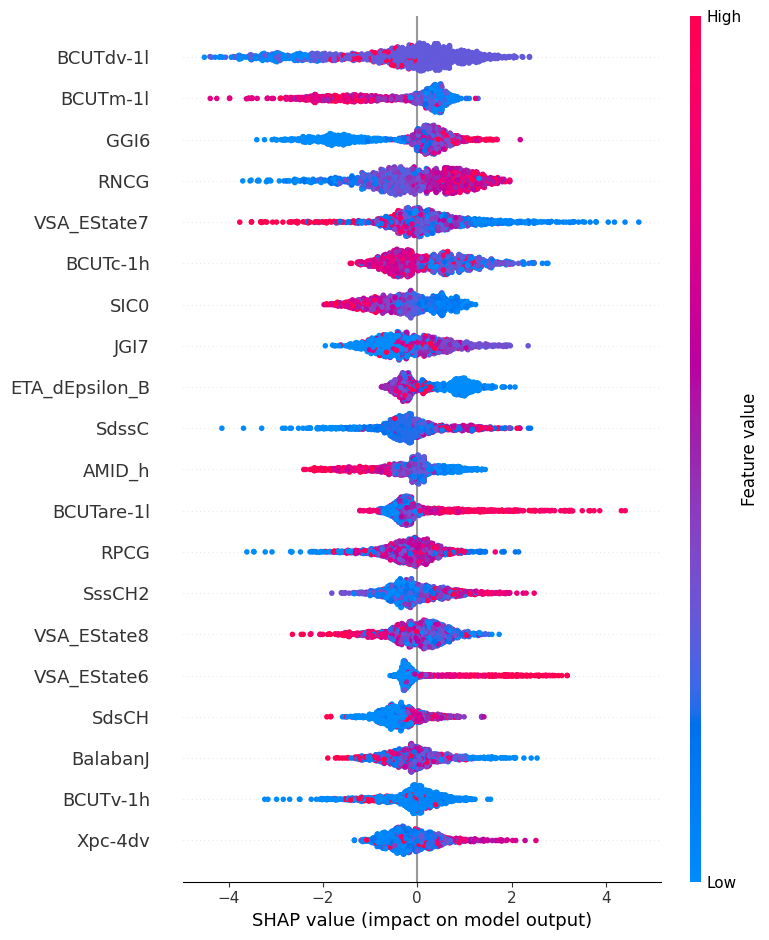

In [26]:
shap.summary_plot(shap_values[:,:,4], test_x)